<h1>Lab 6 - Image Recognition</h1>
<strong>By Ryan West, 2018-04-11</strong>

This project probably took me around 30-40 hours to complete. The writeup part took me around 4-5 hours to do since I wrote my own code for PR curves and MAP. Although the hardest part was writing all the code to build the recognition engine, the part that took the majority of the time was refining the input variables to get good results from the recognizer. Tweaking the parameters I was able to achieve over 50% accuracy at times when discriminating between 20 categories.

<h4>Notes:</h4>
<ul>
    <li> My program assumes that images of category "CATEGORY" are in the folder "./train/CATEGORY", where '.' is the directory containing this jupyter notebook.</li>
    <li> As you scan through this jupyter notebook, you will notice that I have written comments above different cells explaining what you can do with them and when to run them.</li>
</ul>

For my recognition, I used the Caltech dataset using the following classes:
<ul>
    <li>metronome</li>
    <li>menorah</li>
    <li>sunflower</li>
    <li>strawberry</li>
    <li>snoopy</li>
    <li>brain</li>
    <li>buddha</li>
    <li>soccer_ball</li>
    <li>grand_piano</li>
    <li>revolver</li>
    <li>yin_yang</li>
    <li>stop_sign</li>
    <li>pyramid</li>
    <li>nautilus</li>
    <li>scissors</li>
    <li>schooner</li>
    <li>ceiling_fan</li>
    <li>laptop</li>
    <li>inline_skate</li>
    <li>dollar_bill</li>
</ul>

<h2>Description of Feature/Image Representation</h2>
<p>In order to feed images into my SVMs for training and recognition, I have to represent them in a different form. I'll describe my process of deriving this representation for each image. First, I use opencv to find SIFT descriptors in every image. I take a sample of all these SIFT descriptors and perform K-Means on them in 128-dimensional space. The descriptors are then partitioned into 125 regions which become our vocabulary to represent images. </p>
<p> Next, for each image I find all of its SIFT descriptors. I use a nearest-neighbor algorithm with our previously generated vocabulary to find which word each SIFT descriptor is closest to. After accumulating a list of words for each image, I form a histogram of the counts of each word in the image. This histogram of words is the image representation that I feed into my SVMs </p>
<h4>What size vocabulary produces the best classification accuracy?</h4>
<p> I ran trials with varying vocabulary sizes to determine the most effective size. The most effective vocabulary size was the size that consistently produced the highest % accuracy using the code in "Extensive Testing". Below I include a graph showing the accuracy for different vocabulary sizes.</p>
<p><strong>The optimal vocabulary size is 125</strong></p>
<ul>
    <li>v: 50,  37.5%</li>
    <li>v: 50,  40.0%</li>
    <li>v: 50,  40.8%</li>
    <li>v: 75,  53.3%</li>
    <li>v: 75,  50.0%</li>
    <li>v: 75,  46.7%</li>
    <li>v: 100, 51.7%</li>
    <li>v: 100, 46.7%</li>
    <li>v: 100, 54.2%</li>
    <li>v: 125, 55.0%</li>
    <li>v: 125, 53.3%</li>
    <li>v: 125, 50.8%</li>
    <li>v: 150, 47.5%</li>
    <li>v: 150, 45.0%</li>
    <li>v: 150, 43.3%</li>
    <li>v: 150, 50.0%</li>
    <li>v: 175, 32.5%</li>
    <li>v: 175, 30.8%</li>
    <li>v: 175, 32.0%</li>
    <li>v: 200, 27.8%</li>
    <li>v: 200, 19.2%</li>
    <li>v: 200, 27.2%</li>
    <li>v: 200, 29.2%</li>
    <li>v: 200, 44.2%</li>
</ul>


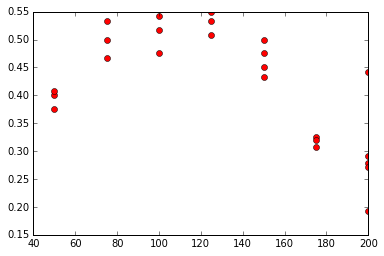

In [1]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

vocab_size_results = [
    (50, .375),
    (50, .400),
    (50, .408),
    (75, .533),
    (75, .500),
    (75, .467),
    (100, .517),
    (100, .475),
    (100, .542),
    (125, .550),
    (125, .533),
    (125, .508),
    (150, .475),
    (150, .450),
    (150, .500),
    (150, .433),
    (175, .325),
    (175, .308),
    (175, .320),
    (200, .278),
    (200, .192),
    (200, .272),
    (200, .292),
    (200, .442)
    ]
x, y = zip(*vocab_size_results)
plt.plot(x,y, 'ro')
plt.show()


<h2>Classification Approach</h2>
<p> In order to classify test images into different categories, I used the sklearn.svm Support Vector Machine. I created an instance of an SVM for each category I would recognize. Each SVM would be trained on the vocabulary histograms for the set of images that belong to the category and histograms for a set of all the other images that do not belong to the category.</p>
<p>When trying to recognize which category a test image belongs to, I run each SVM on the image's histogram. The category for which its SVM returns the highest confidence that it belongs is returned as the category to which the image belongs.</p>


<h2>Beginning of code</h2>
<p>In order to see the output from my code, it is sufficient to simply run all the cells in the jupyter notebook. The first 4 code cells only need to be run once. They declare my classes and methods and then the last of the 4 cells initializes and trains my Recognizer. The cells following these 4 are for testing, you can rerun them to quickly test other images or to perform a batch test which runs with a bunch of test images from every category.</p> 

In [2]:
import cv2
import numpy as np
import os
import glob
import time
from scipy import spatial
from sklearn import svm
from sklearn.cluster import KMeans
from collections import Counter

%matplotlib inline
np.set_printoptions(suppress=True)
matplotlib.rcParams['figure.figsize'] = (4,4)

def plot2d(image, title="", max=None, min=0, cmap="gray"):
    plt.title(title)
    if max == None:
        plt.imshow(image, cmap=cmap, interpolation="none")
    else:
        plt.imshow(image, cmap=cmap, interpolation="none", vmin = min, vmax = max)
    plt.show()

In [3]:
class Recognizer:
    def __init__(self, categories_images, samples_per_image_count, vocab_size, max_images_per_category=25,  verbose=False):
        self.SIFT_DIM = 128
        self.sift = cv2.xfeatures2d.SIFT_create()
        self.samples_per_image_count = samples_per_image_count
        self.vocab_size = vocab_size
        self.max_images_per_category = max_images_per_category
        self.verbose = verbose

        categories_image = self.__limit_images_in_category(categories_images)

        vocab_images = []
        for catgry_img in categories_images:
            vocab_images.extend(catgry_img[1])

        self.vocab = self.__build_vocab(vocab_images)
        self.__alert("building vocab KD Tree...")
# I build a KDTree with the vocabulary words here 
# in order to quickly find which vocabulary word is closest for a feature
        self.vocab_kd_tree = spatial.KDTree(self.vocab)

        start_time = time.time()
        self.categories_bags = self.__get_categories_bags(categories_images)
        elapsed = time.time() - start_time 
        self.__alert("creating bags for all training images took " + str(elapsed) + " seconds")

        self.train(self.categories_bags)

    def __limit_images_in_category(self, categories_images):
        cat_imgs = []
        for i in range(len(categories_images)):
            if len(categories_images[i][1]) > self.max_images_per_category:
                new_cat_imgs = (categories_images[i][0], categories_images[i][1][:self.max_images_per_category])
                cat_imgs.append(new_cat_imgs)

        return cat_imgs




    def __sample_descriptors(self, descriptor_list):
        M = self.samples_per_image_count * len(descriptor_list)
        descriptors_matrix = np.zeros((M, self.SIFT_DIM))

        # Enumerate all images
        for i, img_descs in enumerate(descriptor_list):
            # Select a sample of descriptors from an image
            selections = np.random.permutation(len(img_descs))[0:self.samples_per_image_count]
            img_samples = ([img_descs[x] for x in selections])
            # Add the samples to the descriptors matrix
            for j, sample in enumerate(img_samples):
                descriptors_matrix[i * self.samples_per_image_count + j,:] = sample[:]
        return descriptors_matrix

    def __build_vocab(self, images):
        self.__alert("building vocab...")
        descriptor_list = self.__find_features(images)
        self.__alert("sampling descriptors...")
        descriptors_matrix  = self.__sample_descriptors(descriptor_list)
    
# Here I am clustering with KMeans to form a vocabulary using
# a sample of the SIFT descriptors from each training image
        self.__alert("clustering with K Means.\nThis may take a while...")
        start_time = time.time()
        k_means = KMeans(n_clusters=self.vocab_size)
        k_means.fit(descriptors_matrix)
        vocab  = k_means.cluster_centers_

        elapsed = time.time() - start_time 
        self.__alert("K means took " + str(elapsed) + " seconds")
        return vocab

    def __find_words_in_vocab(self, descriptors):
        words_list = []
        
        descriptor_sample_size = min(self.samples_per_image_count * 3, len(descriptors))
        for descriptor in descriptors[:descriptor_sample_size]:

            word = self.vocab[self.vocab_kd_tree.query(descriptor,1)[1]]
            words_list.append(word)
        return words_list
        
    def __find_features(self, images):
        descs = []
        self.__alert("finding features...")
        for image in images:
            _, descriptors = self.sift.detectAndCompute(image, None)
            descs.append(descriptors)

        return descs
    
    def __get_categories_bags(self, categories_images):
        self.__alert("finding bags of words for all training images...")
        categories_bags = []
        for category, images in categories_images:
            bags_of_words = []
            self.__alert("finding bags for " + category)
            for image in images:
                bag_of_words = self.__build_bag_of_words(image)
                bags_of_words.append(bag_of_words)
            categories_bags.append( (category, bags_of_words) )
        return categories_bags
        

    def __build_training_matrices(self, positive_bags, negative_bags):
        M = len(positive_bags) + len(negative_bags)
        train_matrix = np.zeros((M, self.vocab_size))
        label_matrix = np.zeros((M))

        for i, positive_bag in enumerate(positive_bags):
            train_matrix[i,:] = positive_bag
            label_matrix[i] = 1
            
        for i, negative_bag in enumerate(negative_bags):
            train_matrix[i + len(positive_bags),:] = negative_bag
            label_matrix[i + len(positive_bags)] = -1

        return train_matrix, label_matrix

    def __build_negative_bags(self, categories_bags, category):
        negative_categories = filter(lambda cat_bag: cat_bag[0] != category, categories_bags)
        negative_bags = []
        for neg_cat in negative_categories:
            negative_bags.extend(neg_cat[1])
        return negative_bags


    def train(self, categories_bags):
        self.__alert("training...")
        self.svms = []
        for category, positive_bags in categories_bags:
            self.__alert("building positive bags for " + category)
            positive_bags2 = []
            for positive_bag in positive_bags:
                positive_bags2.append( positive_bag)
            positive_bags = positive_bags2

            self.__alert("building negative bags for " + category)
            negative_bags = self.__build_negative_bags(categories_bags, category)
            self.__alert("building training matrices for " + category)
            train_matrix, label_matrix = self.__build_training_matrices(positive_bags, negative_bags)

# Here I train my SVM for classification of each category.
# Each SVM is trained on data within the category and
# data outside the category
            self.__alert("training " + category + " svm...")
            svm_model = svm.SVC(probability=True)
            svm_model.fit(train_matrix, label_matrix)
            self.svms.append( (category, svm_model) )
        self.__alert("training completed!")

    def __alert(self, msg):
        if self.verbose:
            print msg

# This method performs vector quantization. I am finding SIFT
# descriptors in the image and then finding which words those
# descriptors come from. Then I count each of the words and
# build a histogram from them.
    def __build_bag_of_words(self, image):
        kp, desc = self.sift.detectAndCompute(image, None)
        words = self.__find_words_in_vocab(desc)
        word_tuples = map(lambda w: tuple(w), words)
        word_counts = dict(Counter(word_tuples))
        counts = map(lambda wc: word_counts[wc], word_counts)
        for word in map(lambda w: tuple(w), self.vocab):
            if word not in word_counts:
                word_counts[word] = 0
        total = float(sum(word_counts.values()))
        proportional_word_counts = map(lambda wc: ( wc, word_counts[wc] / total), word_counts)
        bag = sorted(proportional_word_counts, key=lambda pwc: pwc[0])
        bag = map(lambda b: b[1], bag)
        return bag

    def recognize(self, image, output_stats=False):
        self.__alert("recognizing image...")
        bag_of_words = self.__build_bag_of_words(image)
        input = [bag_of_words]
        best_category = None
        best_proximity = 0
        stats = []
        for category, svm_model in self.svms:
            # This code right here uses my SVM to determine which
            # category the input image belongs to.
            # I test the probability of belonging to each category
            # given by each SVM and then return the category for the
            # SVM which gives the highest probability.
            svm_probability = svm_model.predict_proba(input)[0][1]
            if svm_probability > best_proximity:
                best_proximity = svm_probability
                best_category = category
            stats.append( (category, svm_probability) )

        if output_stats:
            return best_category, stats
        else:
            return best_category


<h2>Support Methods</h2>
<p>This cell includes methods that are not part of the image recognition engine but are methods that facilitate loading images/categories and running tests on the images.</p>

In [4]:
def load_images(path):
    image_paths = glob.glob(path)
    images = []
    for image_path in image_paths:
        images.append(cv2.imread(image_path))
#         images.append(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE ))
    return images

def load_categories(category_names):
    categories = []
    for name in category_names:
        imgs = load_images("./train/" + name + "/*")
        if len(imgs) == 0:
            raise Exception("bad category name: " + name)
            sys.exit(0)
        categories.append( (name, imgs ) )
    return categories

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

# This method runs a test using our recognizer to determine 
# whether an image belongs to the correct_category.
# Probabilities for each category are displayed
def test_image(image, correct_category):
    is_correct = False
    output_img = np.copy(image)
    recognized_category, stats = recognizer.recognize(output_img, output_stats=True)

    color = (0,0,255)
    if recognized_category == correct_category:
        is_correct = True
        color = (0, 255, 0)

    confidence = max(map(lambda s: s[1], stats))
    confidence = '{:.1%}'.format(confidence)

    cv2.putText(output_img, recognized_category, (5,30), cv2.FONT_HERSHEY_PLAIN, 1.5, color, 3)
    cv2.putText(output_img, str(confidence), (5,60), cv2.FONT_HERSHEY_PLAIN, 1.5, color, 3)
    output_img = cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB)
    plot2d(output_img, confidence)

    for stat in stats:
        color = bcolors.ENDC
        if stat[0] == recognized_category:
            if recognized_category == correct_category:
                color = bcolors.OKGREEN
            else:
                color = bcolors.FAIL
        print color,'{:<15}{:>6.1%}'.format(stat[0], stat[1])
    return is_correct, output_img
    
# Runs test_image for a bunch of sample data from all of the
# categories that are specified.
def test_recognition(categories, test_samples_per_category):
    correct_matches = 0
    total_tests = len(categories) * test_samples_per_category
    results_imgs = []
    for category, imgs in categories:
        print bcolors.BOLD, '{:-^40}'.format("Category " + category), bcolors.ENDC
        for i in range(test_samples_per_category):
            is_correct, output_img = test_image(imgs[len(imgs) - i - 1], category)
            results_imgs.append(output_img)
            if is_correct:
                correct_matches += 1
                
    print "\n\n\n\n"
    print "accuracy: ", correct_matches, " of ", total_tests
    percent_accuracy = correct_matches / float(total_tests)
    print '{:.1%}'.format(percent_accuracy)
    return results_imgs

<h2>Initializing and Training the Recognizer</h2>
<p>Run the cell below to initialize the Image recognizer. Once it is trained, you can run another cell to test recognition on different inputs. Remember, running the Recognizer initialization/training will take a very long time!</p>

<p>My program assumes that images of category "CATEGORY" are in the folder "./train/CATEGORY", where train is in the same directory as this jupyter notebook.</p>


In [ ]:
category_names = [
    "apricot_tree", "popcorn", "revolver"]
#          "metronome",   "menorah",      "sunflower",    "strawberry",   "snoopy",
#          "brain",       "buddha",       "soccer_ball",  "grand_piano",  "revolver",
#          "yin_yang",    "stop_sign",    "pyramid",      "nautilus",     "scissors",
#          "schooner",    "ceiling_fan",   "laptop",       "inline_skate", "dollar_bill"]

print "loading image files..."
categories = load_categories(category_names)

recognizer = Recognizer(
        categories_images=categories,
        samples_per_image_count=80,
        vocab_size=125, max_images_per_category=15,
        verbose=True)

loading image files...
building vocab...
finding features...
sampling descriptors...
clustering with K Means.
This may take a while...
K means took 13.2680230141 seconds
building vocab KD Tree...
finding bags of words for all training images...
finding bags for apricot_tree
finding bags for popcorn
finding bags for revolver


In [26]:
recognizer.train(recognizer.categories_bags)

training...
building positive bags for apricot_tree
building negative bags for apricot_tree
building training matrices for apricot_tree
training apricot_tree svm...
building positive bags for popcorn
building negative bags for popcorn
building training matrices for popcorn
training popcorn svm...
training completed!


<h2>Test Individual Images</h2>
<p>In order to test individual images that you specify, run the following cell and change the value of IMAGE_PATH to point to the image you want to load. Change CORRECT_CATEGORY to the name of the correct category of the image.</p>
<p>This test will show a thumbnail of the image with a label showing what category it was classified as and the confidence. Below the image it will show the confidence for each category SVM. The highest SVM is highlighted.  Red or green text coloring is used to quickly tell whether the answer was correct.</p>

recognizing image...


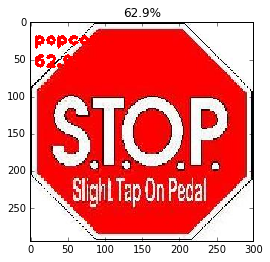

 apricot_tree    46.0%
 popcorn         62.9%


In [7]:
def test_individual_image(path, correct_category):
    image = cv2.imread(path)
    test_image(image, correct_category)
    
IMAGE_PATH = "./train/stop_sign/image_0057.jpg"
CORRECT_CATEGORY = "stop_sign"

test_individual_image(IMAGE_PATH, CORRECT_CATEGORY)

<h2>Extensive Testing</h2>
<p>Run the cell below in order to run recognition tests for many images belonging to all categories.  At the end of the output there is a summary of how many images were correctly labeled and the percent of correct labels. </p>

Note: The images used for this batch testing are not images from the training set. My recognizer trains on only the first 30 images per category, while these are taken from the last TEST_IMAGES_PER_CATEGORY images in each category. The only time that there would be overlap is if there are fewer than (30 + TEST_IMAGES_PER_CATEGORY) in a certain category, but that rarely happens.

 ---------Category apricot_tree---------- 
recognizing image...


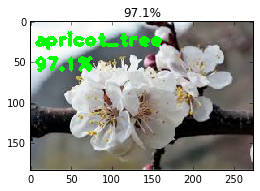

 apricot_tree    97.1%
 popcorn         15.8%
 revolver         4.9%
recognizing image...


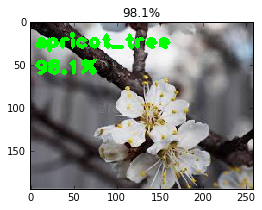

 apricot_tree    98.1%
 popcorn          6.1%
 revolver        24.3%
recognizing image...


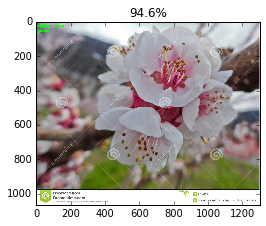

 apricot_tree    94.6%
 popcorn          2.4%
 revolver        87.7%
recognizing image...


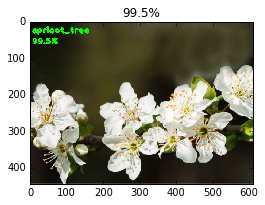

 apricot_tree    99.5%
 popcorn         12.3%
 revolver         3.1%
recognizing image...


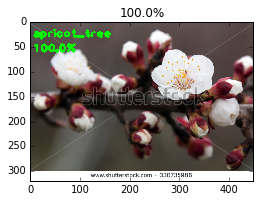

 apricot_tree   100.0%
 popcorn          3.1%
 revolver        14.2%
recognizing image...


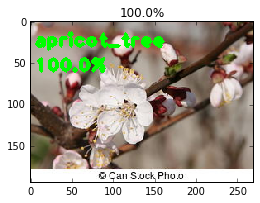

 apricot_tree   100.0%
 popcorn          5.5%
 revolver         5.4%
 ------------Category popcorn------------ 
recognizing image...


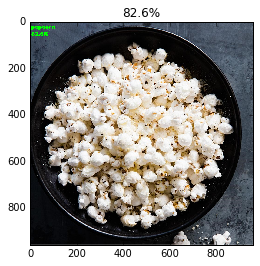

 apricot_tree    44.5%
 popcorn         82.6%
 revolver        59.0%
recognizing image...


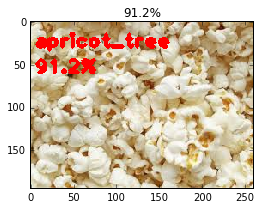

 apricot_tree    91.2%
 popcorn         55.2%
 revolver         0.9%
recognizing image...


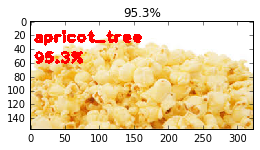

 apricot_tree    95.3%
 popcorn         91.4%
 revolver         0.1%
recognizing image...


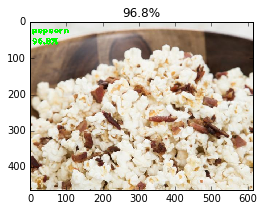

 apricot_tree    82.8%
 popcorn         96.8%
 revolver         0.1%
recognizing image...


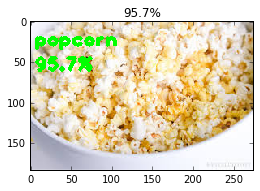

 apricot_tree    77.5%
 popcorn         95.7%
 revolver         0.1%
recognizing image...


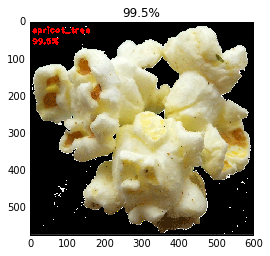

 apricot_tree    99.5%
 popcorn         16.4%
 revolver         6.7%
 -----------Category revolver------------ 
recognizing image...


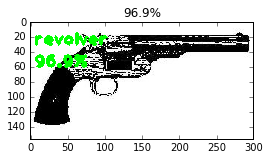

 apricot_tree    15.0%
 popcorn          3.5%
 revolver        96.9%
recognizing image...


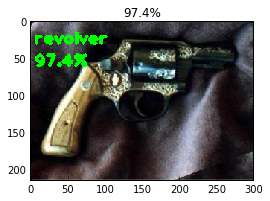

 apricot_tree    87.6%
 popcorn          0.8%
 revolver        97.4%
recognizing image...


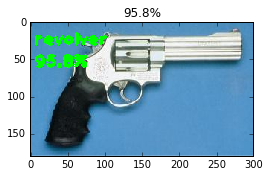

 apricot_tree    38.1%
 popcorn          6.4%
 revolver        95.8%
recognizing image...


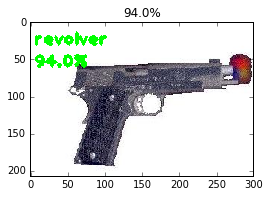

 apricot_tree    73.8%
 popcorn          1.5%
 revolver        94.0%
recognizing image...


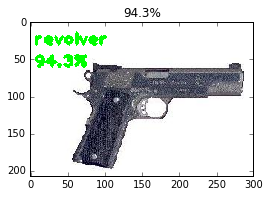

 apricot_tree    85.8%
 popcorn          2.0%
 revolver        94.3%
recognizing image...


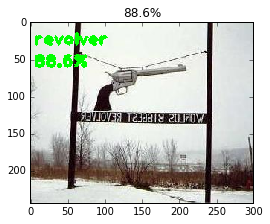

 apricot_tree    75.3%
 popcorn          2.2%
 revolver        88.6%





accuracy:  15  of  18
83.3%


In [29]:
TEST_IMAGES_PER_CATEGORY = 6
results_imgs = test_recognition(categories, TEST_IMAGES_PER_CATEGORY)

# save_results(results_imgs)


# recognized_category, stats = recognizer.recognize(output_img, output_stats=True)

<h2>PR Curves</h2>
<p>Below, I show the PR curves for all the different categories that I recognize for. <strong>I implemented my own PR curve generating methods</strong> because I thought that I would learn more by doing that.</p>

In [9]:
# import random

def label_confidences(positive_category, confidences, test_data, threshold):
    labels = []
    labeled_category = map(lambda c: c >= threshold, confidences)
    for i in range(len(labeled_category)):
        if (test_data[i][1] == positive_category):
            if (labeled_category[i]):
                labels.append('tp')
            else:
                labels.append('fn')
        else:
            if (labeled_category[i]):
                labels.append('fp')
            else:
                labels.append('tn')
    return labels
        
def generate_test_data(categories, image_count):
    train_data = []
    image_data = load_categories(categories)
    for category, imgs in image_data:
        cat_image_count = min(image_count, len(imgs))
        train_data.extend(map(lambda img: (img, category),imgs[:cat_image_count]))
#     random.shuffle(train_data)
    return train_data
        
def calculate_precision_recall(confidence_labels):
    counts = dict(Counter(confidence_labels))
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    if 'tp' in counts:
        tp = counts['tp']
    if 'fp' in counts:
        fp = counts['fp']
    if 'tn' in counts:
        tn = counts['tn']
    if 'fn' in counts:
        fn = counts['fn']
    
    if tp + fp > 0:
        precision = tp / float(tp + fp)
    else:
        precision = 1.0
    if tp + fn > 0:
        recall = tp / float(tp + fn)
    else:
        recall = 1.0
#     print 'tp {:<6} fp {:<6} tn {:6} fn {:6}'.format(tp, fp, tn, fn)
    return precision, recall
    
def generate_PR_curves(test_categories, test_data):
    is_verbose = recognizer.verbose
    recognizer.verbose = False
    prs = []
    stats = []
    for image, true_category in test_data:
        _, stat = recognizer.recognize(image, output_stats=True)
        stats.append(stat)
    for test_category in test_categories:
        pr = []
        confidences = []
        for stat in stats:
            confidence = map(lambda s: s[1], filter(lambda s: s[0] == test_category, stat))[0]
            confidences.append(confidence)
        for threshold in np.linspace(0.0, 1.0, 200):
            confidence_labels = label_confidences(test_category, confidences, test_data, threshold)
#             print threshold
            precision, recall = calculate_precision_recall(confidence_labels)
            pr.append( (precision, recall) )
        prs.append(pr)
    recognizer.verbose = is_verbose
    return prs
    
test_data = generate_test_data([
         "metronome",   "menorah",      "sunflower",    "strawberry",   "snoopy",
         "brain",       "buddha",       "soccer_ball",  "grand_piano",  "revolver",
         "yin_yang",    "stop_sign",    "pyramid",      "nautilus",     "scissors",
         "schooner",    "ceiling_fan",   "laptop",       "inline_skate", "dollar_bill"], 20)
# pr_categories = ["schooner", "scissors", "snoopy", "pyramid", "nautilus"]
pr_categories= ["metronome",   "menorah",      "sunflower",    "strawberry",   "snoopy",
         "brain",       "buddha",       "soccer_ball",  "grand_piano",  "revolver",
         "yin_yang",    "stop_sign",    "pyramid",      "nautilus",     "scissors",
         "schooner",    "ceiling_fan",   "laptop",       "inline_skate", "dollar_bill"]
prs = generate_PR_curves(pr_categories, test_data)

for i in range(len(pr_categories)):
    precision, recall = zip(*prs[i])
    plt.title( pr_categories[i])
    plt.plot(recall, precision, 'r-')
    plt.show()


KeyboardInterrupt: 

<h2>Mean Average Precision</h2>
<h4>MAP</h4>
<p>For the optimal vocabulary size of 125, the MAP among all the categories is: 0.7707. Although the MAP for a vocab size of 125 isn't the highest MAP, a vocabulary size of 125 had the highest percentage correct when discriminating between the 20 categories out of all the vocab sizes that I picked. I believe this happened because the PR curve (and MAP) is basically a binary comparison (does it belong to the category or not), while my actual recognition engine picks the category of the SVM which has the highest confidence.</p>
<h4>How does this change with different sized vocabularies?</h4>
Here are the results for MAPs with various vocab sizes. It seemed like, in general, the MAP decreased as I increased the vocab size. See my graph below...
<ul>
    <li>Vocab size: 50, MAP:  0.8275, 0.8161</li>
    <li>Vocab size: 75, MAP:  0.8144, 0.8040</li>
    <li>Vocab size: 100, MAP: 0.8189, 0.8077</li>
    <li>Vocab size: 125, MAP: 0.7707, 0.7608</li>
    <li>Vocab size: 150, MAP: 0.7267, 0.7355</li>
    <li>Vocab size: 175, MAP: 0.7898</li>
    <li>Vocab size: 200, MAP: 0.6913, 0.7355</li>
</ul>

In [ ]:
def riemann_sum(curve):
    min_x = min(curve, key=lambda p: p[1])[1]
    max_x = max(curve, key=lambda p: p[1])[1]
    slice_width = float(max_x - min_x) / len(curve)
    area_under_curve = 0
    for point in curve:
        area_under_curve += point[0] * slice_width
    return area_under_curve
    
def calculate_mean_average_precision(prs):
    areas = map(riemann_sum, prs)
    average = sum(areas) / float(len(prs))
    return average
    
average = calculate_mean_average_precision(prs)
print 'Mean Average Precision is: {0}'.format(average)




map_results = [
    (50, 0.8275),
    (50, 0.8161),
    (75, 0.8144),
    (75, 0.8040),
    (100, 0.8189),
    (100, 0.8077),
    (125, 0.7707),
    (125, 0.7608),
    (175, 0.7898),
    (200, 0.6913),
    (200, 0.7355)
    ]
x, y = zip(*map_results)
plt.plot(x,y, 'ro')
plt.show()